# ALOS/ALOS2 PALSAR <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


* **Products used:** 
[alos_palsar_mosaic](https://explorer.dev.digitalearth.africa/products/alos_palsar_mosaic)

## Background

The ALOS/ALOS2 PALSAR annual mosaic is a global 25 m resolution dataset that combines data from many images captured by JAXA’s PALSAR and PALSAR-2 sensors on ALOS-1 and ALOS-2 satellites respectively. This product contains radar measurement in L-band and in HH and HV polarizations. It has a spatial resolution of 25m and is available annually for 2007 to 2010 (ALOS/PALSAR) and 2015 to 2018 (ALOS-2/PALSAR-2).
These mosaic data is part of a global [dataset](https://www.eorc.jaxa.jp/ALOS/en/palsar_fnf/fnf_index.htm) provided by the Japan Aerospace Exploration Agency (JAXA) Earth Observation Research Center.

DE Africa's ALOS/ALOS-2 PALSAR/PALSAR-2 mosaic is a Normalized Radar Backscatter data, for which Radiometric Terrain Correction (RTC) has been applied so data acquired with different imaging geometries over the same region.The relevant coverage and metadata of this dataset can be viewed on [DE Africa Metadata Explorer](https://explorer.dev.digitalearth.africa/products/alos_palsar_mosaic/extents) and forms a single, cohesive Analysis Ready Data (ARD) package, which allows you to analyse radar backscatter data as-is without the need to apply additional corrections.

**Important details:**

* SAR annual mosaic product specifications
    * Number of bands: `5` (`0` is `no-data`)
    * To achieve backscatter in decibel unit, convert backscatter values in Digital Number (DN) using $ 10 * log10(DN^2) - 83.0 $

* Mask specification includes `0` for `no-data`, `50` for water, `100` for lay_over, `150` for shadowing and `255` for land
* Native pixel alignment is `centre`
* Date-range: 2007 to 2018
* Spatial resolution: 25 x 25 m

For a detailed description of DE Africa's ALOS/ALOS2 PALSAR archive, see the DE Africa's [ALOS/ALOS2 technical specifications documentation]() **placeholder link - to update**

## Description

In this notebook we will load **ALOS PALSAR** data using [dc.load()](../Beginners_guide/03_Loading_data.ipynb) to return a time series of satellite images from a single sensor. The returned `xarray.Dataset` will contain analysis ready images with the invalid pixels masked out.

Topics covered include:
1. Inspecting the ALOS PALSAR products and measurements available in the datacube
2. Using the native `dc.load()` function to load in ALOS PALSAR data 
3. Applying a single band analysis to different polarisation 

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [8]:
%matplotlib inline
import datacube
import sys
import math 
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from xarray.ufuncs import isfinite

from deafrica_tools.plotting import rgb 
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="ALOS_Viewer")

## Available products and measurements

### List products

We can use datacube's `list_products` functionality to inspect DE Africa's SAR products that are available in the datacube. The table below shows the product names that we will use to load the data, a brief description of the data, and the satellite instrument that acquired the data.

In [3]:
productA = "alos_palsar_mosaic"

### List measurements

We can further inspect the data available for each SAR product using datacube's `list_measurements` functionality. The table below lists each of the measurements available in the data.

In [4]:
measurements = dc.list_measurements()
measurements.loc[productA]

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
hh,hh,int16,1,0,[hh],NaN
hv,hv,int16,1,0,[hv],NaN
date,date,int16,1,0,[date],NaN
linci,linci,uint8,1,0,"[local incidence angle, linci, incidence]",NaN
mask,mask,uint8,1,0,[mask],"{'category': {'bits': [0, 1, 2, 3, 4, 5, 6, 7]..."


## Load ALOS PALSAR dataset using `dc.load()`

Now that we know what products and measurements are available for the products, we can load data from the datacube using `dc.load`.

In the example below, we will load ALOS PALSAR for Cairo and its surrounding in Egypt between 2007 and 2018. 

We will load data from three spectral satellite bands, as well as masked data (`'mask'`). By specifying `output_crs='EPSG:6933'` and `resolution=(-25, 25)`, we request that datacube reproject our data to the African Albers coordinate reference system (CRS), with 25 x 25 m pixels. 

> Note: For a more general discussion of how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook.



In [10]:
# Setting the query for area in the proximity of Cairo 
lon = (30.45, 31.42)
lat = (29.82, 30.45)
query = {"x": lon,
         "y": lat,
         "output_crs": 'epsg:6933',
         "resolution":(-25,25),
         "time": ("2007-07-02", "2018-07-31")}

In [11]:
#loading the data with the mask band included 
bands = ['hh','hv','mask']
ds = dc.load(product='alos_palsar_mosaic',
             measurements=bands,
             **query)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 8, x: 3744, y: 2791)
Coordinates:
  * time         (time) datetime64[ns] 2007-07-02T12:00:00 ... 2018-07-02T12:...
  * y            (y) float64 3.709e+06 3.709e+06 ... 3.639e+06 3.639e+06
  * x            (x) float64 2.938e+06 2.938e+06 ... 3.032e+06 3.032e+06
    spatial_ref  int32 6933
Data variables:
    hh           (time, y, x) int16 1506 1260 1231 1402 ... 2970 2136 3405 3757
    hv           (time, y, x) int16 617 522 507 553 565 ... 872 958 725 1004 573
    mask         (time, y, x) uint8 255 255 255 255 255 ... 255 255 255 255 255
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


In [12]:
# Set the timesteps to visualise
timesteps = [2, 3, 5]

#you need to rename bands here to red gree blue for demonstration 

# Generate RGB plots at each timestep
rgb(ds, index=timesteps)

ValueError: rgb() bands do not match band names in dataset. Note the default rgb() bands are ['red', 'green', 'blue'].

In [7]:
ds['hhhv'] = ds.hh / ds.hv

### Visualise the selected area 

In [8]:
display_map(x=lon, y=lat)

In [10]:
#convert DN to db values
ds['hh'].values =  10 * np.log10(ds.hh.values**2) - 83.0
ds['hv'].values =  10 * np.log10(ds.hv.values**2) - 83.0 
ds['hhhv'].values = 10 * np.log10(ds.hhhv.values**2) - 83.0 

In [11]:
hist_ds = ds[['hh','hv','hhhv']]
hist_ds = hist_ds.where(isfinite(hist_ds))

In [12]:
hist_ds

<xarray.Dataset>
Dimensions:      (time: 1, x: 3744, y: 2791)
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02T12:00:00
  * y            (y) float64 3.709e+06 3.709e+06 ... 3.639e+06 3.639e+06
  * x            (x) float64 2.938e+06 2.938e+06 ... 3.032e+06 3.032e+06
    spatial_ref  int32 6933
Data variables:
    hh           (time, y, x) float32 -50.940514 nan -50.48609 ... nan -51.16671
    hv           (time, y, x) float32 -50.256653 -51.39402 ... -48.212105
    hhhv         (time, y, x) float64 -73.61 -79.11 -74.27 ... -72.39 -66.67
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

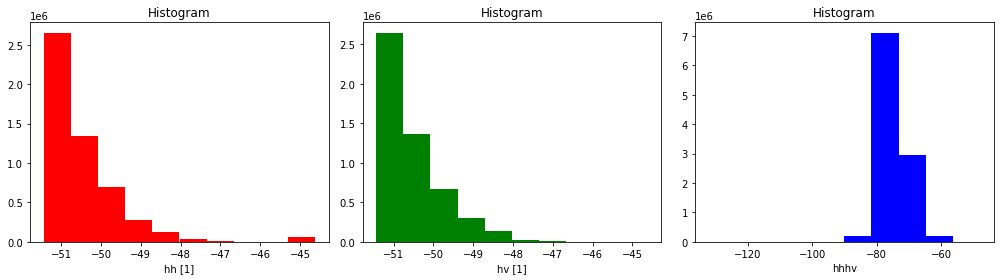

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
hist_ds.hh.plot.hist(ax=ax[0], facecolor='red')
hist_ds.hv.plot.hist(ax=ax[1], facecolor='green')
hist_ds.hhhv.plot.hist(ax=ax[2], facecolor='blue')
plt.tight_layout()
plt.show()

In [46]:
#creation of a new band (HH/HV = hhhv) for RGB display 


<xarray.Dataset>
Dimensions:      (time: 1, x: 3744, y: 2791)
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02T12:00:00
  * y            (y) float64 3.709e+06 3.709e+06 ... 3.639e+06 3.639e+06
  * x            (x) float64 2.938e+06 2.938e+06 ... 3.032e+06 3.032e+06
    spatial_ref  int32 6933
Data variables:
    hh           (time, y, x) float32 -40.084312 nan ... nan -39.053905
    hv           (time, y, x) float32 -43.36779 -38.045113 ... -54.877556
    mask         (time, y, x) uint8 255 255 255 255 255 ... 255 255 255 255 255
    hhhv         (time, y, x) float32 0.9242876 nan nan ... nan nan 0.7116553
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

## Single Data Analysis 

In [48]:
#choose a single acquisition by its index(listed above)
acq_ind_to_show=0

In [49]:
hist_ds = ds.isel(time=acq_ind_to_show)[['hh','hv']]
hist_ds = hist_ds.where(isfinite(hist_ds))

min_per_data_var = hist_ds.quantile(0.001).to_array().values
min_val = min_per_data_var[np.isfinite(min_per_data_var)].min()

max_per_data_var = hist_ds.quantile(0.999).to_array().values
max_val = max_per_data_var[np.isfinite(max_per_data_var)].max()

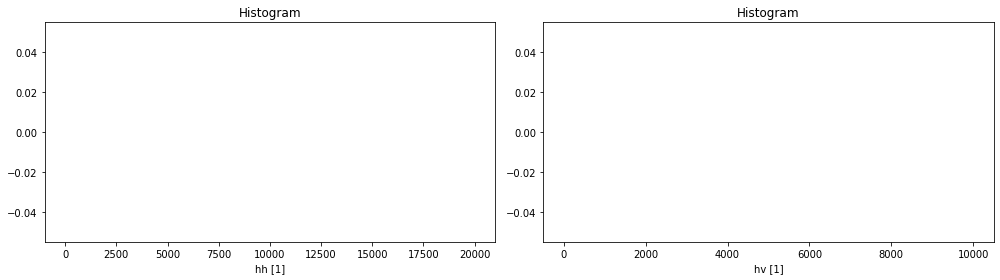

In [50]:
#Plotting the histogram of each polarisation bands in ALOS dataset 
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ds.isel(time=acq_ind_to_show).hh.plot.hist(ax=ax[0], bins=100,range=(0,20000), facecolor='green')
ds.isel(time=acq_ind_to_show).hv.plot.hist(ax=ax[1], bins=100,range=(0,10000), facecolor='red')

plt.tight_layout()
plt.show()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [12]:
print(datacube.__version__)

1.8.4.dev52+g07bc51a5


**Last Tested:**

In [13]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-04-19'